### 1. Импорты

In [170]:
# Ячейка 1: Импорты
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats # Для QQ-plot и преобразования Бокса-Кокса
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Настройки для отображения графиков
%matplotlib inline
plt.style.use('ggplot') # Красивый стиль графиков
# Увеличим стандартный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# Отключим некоторые предупреждения для чистоты вывода (можно закомментировать, если хотите видеть все)
import warnings
warnings.filterwarnings('ignore')

### 2. Извлечение данных из файлов

In [171]:
# Настройка путей к данным
PATH = "data"
FILETEST = os.path.join(PATH, "test.csv")    
FILETRAIN = os.path.join(PATH, "train.csv") 

df_test = pd.read_csv(FILETEST)
df_train = pd.read_csv(FILETRAIN)

df_test_original = df_test.copy()

# df_train.head(10)
df_train.info()
# df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Что бросается в глаза сразу же:
1. **`Id`**. Его можно удалить, так как в `pandas` они автоматически создаются.
2. **`MSSubClass`** переменная числовая, хотя возможно стоит разделить на несколько столбцов object, которые будут более детально отображать данные о постройке. Можно разделить на следующие столбцы: 
    - сколько этажей 
    - является ли постройка **1946 Г. И НОВЕЕ** или **1945 Г. И СТАРШЕ**, есть точный показатель в **`YearBuilt`**. Так же есть и **`YearRemodAdd`** - год реконструкции.
    - стиль постройки, который также есть в параметрах **`BldgType`** (Тип жилья) и **`HouseStyle`** (Стиль жилья) 
3. **`LotFrontage`** указана не везде
4. **`Alley`** мало значений, видимо значение `NA` (Нет переулка/аллеи) автоматически приводится к `NuN`
5. **`Utilities`** стоит немного преобразовать. Создать столбцы: газ, вода, электричество, канализация.
6. **`LandSlope`** стоит обозначить цифрами например:
    *   `Gtl`: Пологий уклон 1
    *   `Mod`: Умеренный уклон 2
    *   `Sev`: Крутой уклон 3
7. **`Condition1`** и **`Condition2`** явно надо преобразовывать. Что тут можно выделить с первого взгляда:
    * видно, что тут тоже указывается наличие поблизости парка или зеленой зоны, как и в **`MSZoning`**.
    * есть такие категории как:
        *   `RRNe`: В пределах 200 футов от железной дороги Восток-Запад
        *   `RRAe`: Рядом с железной дорогой Восток-Запад
        *   `RRNn`: В пределах 200 футов от железной дороги Север-Юг
        *   `RRAn`: Рядом с железной дорогой Север-Юг.
        ---
        их думаю стоит объедининь в 1 столбец. указывать 0 - нет жд по близости, 1 - в пределах 200 футов жд, 2 - рядом жд.
        Tак же поступить с:
        *   `Artery`: Рядом с магистральной улицей
        *   `Feedr`: Рядом с второстепенной улицей (подъездной)
        ---
        Создать также столбец наличия парка или зеленой зоны по близости.
        
8. **`YearBuilt`** **`YearRemodAdd`**, **`GarageYrBlt`**. думаю стоит нормализовать данные признаки для удобства работы с ними модели. Можно найти самый поздний год и вычитать из него остальные значения.
9. **`Exterior1st`** и **`Exterior2nd`** стоит изучить более детально. 
10. **`MasVnrType`** и **`MasVnrArea`** имеют отсутствующие значения. странно что **`MasVnrType`** гораздо меньше чем **`MasVnrArea`**
11. **`ExterQual`** и **`ExterCond`**, **`HeatingQC`**, **`KitchenQual`**, **`GarageQual`**, **`GarageCond`**, оценки стоит перевести в числа
12. **`BsmtQual`** думаю тоже стоит перевести в числовой формат обозначить от 5 (отлично) до 0 (нет подвала). так же **`BsmtCond`** и **`BsmtExposure`**
13. Непонятно чем **`BsmtFinType1`** отличается от **`BsmtFinType2`**. Если это части подвала, то можно их так же по цифрам оценки обозначать. Также есть категории **`BsmtFinSF1`**, **`BsmtFinSF2`**, **`BsmtUnfSF`** и **`TotalBsmtSF`**. Если **`TotalBsmtSF`** равняется сумме площадей разных типов (что надо проверить), то необходимость данного столбца отпадает. И непонятно почему где-то значение 1422 а где-то 1423. Нужно изучить этот один случай.
14. **`CentralAir`** - категории да и нет стоит перевести в 1 и 0.
15. **`Electrical`** - возможно тоже стоит перевести в оценки или разбить на другие категории. Интересно что у одного значение отсутствует. Возможно это стоит считать как отсутствие электропроводки.
16. **`Functional`**, **`FireplaceQu`**, **`GarageFinish`**, **`PavedDrive`** - перевести в числовой формат
17. **`PoolQC`**, **`Fence`** - перевести в числа
18. **`MiscFeature`** - интересный столбец который содержит некоторую полезную информацию. Думаю стоит создать столбец количество гаражей, и наличие категорий которые тут присутствуют.
19. **`MoSold`** и **`YrSold`** стоит обрабатывать в совокупности. думаю стоит опять же найти самую позднюю дату и вычитать из нее количество месяцев.
20. **`SaleType`** так же содержит интересную информацию например 
    *   `Con`: Контракт с 15% первоначальным взносом, обычные условия
    *   `ConLw`: Контракт с низким первоначальным взносом и низкой процентной ставкой
    *   `ConLI`: Контракт с низкой процентной ставкой
    *   `ConLD`: Контракт с низким первоначальным взносом
    ---
    данные столбы следует преобразовать в 2 столбца. 
    *   `WD`: Гарантийный акт (Warranty Deed) - Обычная продажа
    *   `CWD`: Гарантийный акт - Продажа за наличные
    *   `VWD`: Гарантийный акт - Заем для ветеранов (VA Loan)
    ---
    тоже переработать в другие столбцы
    *   `New`: Только что построенный и проданный дом - не несет в себе новой информации. Остальные категории думаю оставить.

*Думаю сначала попробовать обучить модель на данных как есть, потом постепенно изменять таблицу и оценивать то или иное изменение.*

### 3. Обработка пропущенных значений

In [172]:
# Заполним нулями недостающие числовые значения
if df_test['LotFrontage'].isnull().any():
    df_test['LotFrontage'] = 0
if df_train['LotFrontage'].isnull().any():
    df_train['LotFrontage'] = 0

if df_test['MasVnrArea'].isnull().any():
    df_test['MasVnrArea'] = 0
if df_train['MasVnrArea'].isnull().any():
    df_train['MasVnrArea'] = 0

# Удалим столбец год постройки гаража для простоты, так-как не понятно как обрабатывать NuN значения. Удаляем Id.
# df_train.drop('GarageYrBlt', axis=1, inplace=True)
columns_to_drop = ['GarageYrBlt', 'Id']
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)


### 4. Подготовка данных для обучения

In [173]:
# Определение целевой переменной и признаков
target = 'SalePrice'
categorical_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Создание копий для обработки
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

print(f"\nРазмер до One-Hot Encoding:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# One-Hot Encoding для категориальных признаков
df_train_processed = pd.get_dummies(
    df_train_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)
df_test_processed = pd.get_dummies(
    df_test_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)

# Выравнивание столбцов между train и test
train_cols = df_train_processed.drop(target, axis=1, errors='ignore').columns.tolist()
test_cols = df_test_processed.columns.tolist()

# Добавление отсутствующих столбцов в test
for col in train_cols:
    if col not in test_cols:
        df_test_processed[col] = 0

# Удаление лишних столбцов из test
for col in test_cols:
    if col not in train_cols:
        print(f"ВНИМАНИЕ: Удаляем столбец '{col}' из test набора")
        df_test_processed.drop(col, axis=1, inplace=True)

print(f"\nРазмер после обработки:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# Разделение на признаки и целевую переменную
X = df_train_processed.drop(target, axis=1)
y = df_train_processed[target]
X_test_final = df_test_processed.copy()


# Разделение на обучающую и валидационную выборки
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
# )
y_log = np.log1p(y) 
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, 
    test_size=0.2, 
    random_state=42, 
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

df_train_processed.info()
df_test_processed.info()


Размер до One-Hot Encoding:
Train: (1460, 79), Test: (1459, 78)

Размер после обработки:
Train: (1460, 244), Test: (1459, 243)

Разделение данных:
X_train: (1168, 243), y_train: (1168,)
X_val: (292, 243), y_val: (292,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 244 entries, MSSubClass to SaleCondition_Partial
dtypes: int64(244)
memory usage: 2.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 243 entries, MSSubClass to MiscFeature_TenC
dtypes: float64(8), int64(235)
memory usage: 2.7 MB


### 5. Преобразование в pytorch тензоры

In [174]:
# Преобразование в тензоры PyTorch
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_log.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

print("Данные преобразованы в тензоры PyTorch")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

Данные преобразованы в тензоры PyTorch
X_train_tensor: torch.Size([1168, 243])
y_train_tensor: torch.Size([1168, 1])


### 6. Создание Dataset и DataLoader

In [175]:
class HousesDataset(Dataset):
    """Класс для работы с данными Titanic"""
    
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels
        self.is_test = labels is None
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item_features = self.features[idx]
        if self.is_test:
            return item_features
        else:
            item_labels = self.labels[idx]
            return item_features, item_labels

# Создание datasets
train_dataset = HousesDataset(X_train_tensor, y_train_tensor)
val_dataset = HousesDataset(X_val_tensor, y_val_tensor)
test_dataset = HousesDataset(X_test_tensor)

# Создание dataloaders
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader'ы созданы с размером батча: {BATCH_SIZE}")


DataLoader'ы созданы с размером батча: 128


### 7. Определение модели

In [176]:
class LogisticRegressionModel(nn.Module):
    """Модель логистической регрессии с батч-нормализацией"""
    
    def __init__(self, num_input_features, num_output_features):
        super(LogisticRegressionModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_input_features)
        self.linear = nn.Linear(num_input_features, num_output_features)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.linear(x)
        return x
    
class DeeperRegressionModel(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(DeeperRegressionModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_input_features)
        self.fc1 = nn.Linear(num_input_features, 128) # Пример скрытого слоя
        self.relu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2) # Добавим Dropout для регуляризации
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(64)
        self.output_layer = nn.Linear(64, num_output_features)

    def forward(self, x):
        x = self.bn1(x)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.bn2(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.bn3(x)
        x = self.output_layer(x)
        return x

# Создание модели
input_features = X_train_tensor.shape[1]
output_units = 1
DeeperRegressionModel
# model = LogisticRegressionModel(input_features, output_units)
model = DeeperRegressionModel(input_features, output_units)
print("\nАрхитектура модели:")
print(model)


Архитектура модели:
DeeperRegressionModel(
  (bn1): BatchNorm1d(243, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=243, out_features=128, bias=True)
  (relu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


### 8. Настройка обучения

In [177]:
# Определение функции потерь и оптимизатора
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss() # Используем MSE для расчета среднего квадрата ошибок на логарифмах

    def forward(self, y_pred, y_true):
        # Цены не могут быть отрицательными. Если модель может предсказать отрицательные значения,
        # их нужно "отсечь" (clamp) до нуля перед взятием логарифма.
        y_pred_clamped = torch.clamp(y_pred, min=0.0)
        
        # Используем log1p(x) = log(1+x) для численной стабильности и корректной обработки нулей
        log_y_pred = torch.log1p(y_pred_clamped)
        log_y_true = torch.log1p(y_true) # Предполагаем, что истинные цены всегда >= 0
        
        # Вычисляем MSE на логарифмированных значениях
        mse_on_logs = self.mse(log_y_pred, log_y_true)
        
        # RMSLE это корень из MSE на логарифмах
        # Добавляем небольшой эпсилон для предотвращения NaN градиентов, если mse_on_logs очень близок к 0
        rmsle = torch.sqrt(mse_on_logs + 1e-8) 
        return rmsle


criterion = nn.MSELoss()
# criterion = RMSLELoss()
learning_rate = 0.004
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Планировщик скорости обучения
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print("Настройка обучения завершена:")
print(f"Функция потерь: {criterion}")
print(f"Оптимизатор: {optimizer}")

Настройка обучения завершена:
Функция потерь: MSELoss()
Оптимизатор: RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.004
    maximize: False
    weight_decay: 0.0001
)


### 9. Цикл обучения

In [178]:
# Ячейка 9: Цикл обучения (обновленная)

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nОбучение будет производиться на: {device}")
model.to(device)

# Гиперпараметры
num_epochs = 200
train_losses = []
val_losses = []

print(f"\nНачинаем обучение на {num_epochs} эпох...")

for epoch in range(num_epochs):
    # Фаза обучения
    model.train()
    current_epoch_train_loss = 0.0
    
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels) # Здесь теперь RMSLELoss
        loss.backward()
        optimizer.step()
        
        current_epoch_train_loss += loss.item() * features.size(0)
    
    epoch_train_loss = current_epoch_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Фаза валидации
    model.eval()
    current_epoch_val_loss = 0.0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels) # Здесь теперь RMSLELoss
            current_epoch_val_loss += loss.item() * features.size(0)
            

    
    epoch_val_loss = current_epoch_val_loss / len(val_loader.dataset)

    
    val_losses.append(epoch_val_loss)
    
    # Обновление планировщика
    scheduler.step(epoch_val_loss) # Валидационная потеря (RMSLE) используется для планировщика
    current_lr = optimizer.param_groups[0]['lr']
    
    # Вывод результатов эпохи
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss (RMSLE): {epoch_train_loss:.4f}") 
        print(f"  Val Loss (RMSLE): {epoch_val_loss:.4f}")  
        print(f"  Learning Rate: {current_lr:.6f}")
        print("-" * 50)

print("\nОбучение завершено!")


Обучение будет производиться на: cuda

Начинаем обучение на 200 эпох...
Эпоха [1/200]:
  Train Loss (RMSLE): 132.6568
  Val Loss (RMSLE): 554.5044
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [20/200]:
  Train Loss (RMSLE): 50.7002
  Val Loss (RMSLE): 47.3857
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [40/200]:
  Train Loss (RMSLE): 1.7617
  Val Loss (RMSLE): 0.3335
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [60/200]:
  Train Loss (RMSLE): 0.8464
  Val Loss (RMSLE): 0.0891
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [80/200]:
  Train Loss (RMSLE): 0.5044
  Val Loss (RMSLE): 0.0743
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [100/200]:
  Train Loss (RMSLE): 0.2574
  Val Loss (RMSLE): 0.0427
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [120/200]:
  Train Lo

### 10. Визуализация результатов

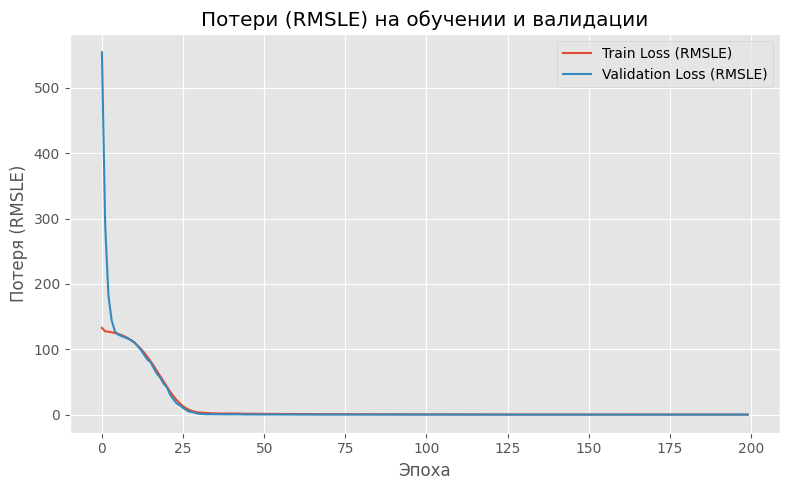

In [179]:
# Ячейка 10: Визуализация результатов (обновленная)

plt.figure(figsize=(8, 5)) # Можно сделать один график поменьше

plt.plot(train_losses, label='Train Loss (RMSLE)')
plt.plot(val_losses, label='Validation Loss (RMSLE)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря (RMSLE)')
plt.legend()
plt.title('Потери (RMSLE) на обучении и валидации')

plt.tight_layout()
plt.show()

### 11. Создание submission файла

In [184]:
model.eval()
all_predictions = []

with torch.no_grad():
    for features_batch in test_loader:
        features_batch = features_batch.to(device)
        outputs_logits = model(features_batch)
        predicted_probs = torch.expm1(outputs_logits)
        all_predictions.extend(predicted_probs.cpu().numpy().flatten().tolist())

print(f"Предсказания для {len(all_predictions)} тестовых примеров сгенерированы.")

# Создание submission файла
if 'Id' in df_test_original.columns:
    if len(df_test_original) == len(all_predictions):
        submission_df = pd.DataFrame({
            'Id': df_test_original['Id'],
            target: all_predictions
        })
        
        submission_filename = 'submission_house_prices.csv'
        submission_df.to_csv(submission_filename, index=False)
        
        print(f"\nSubmission файл '{submission_filename}' успешно создан.")
        print("Первые 5 строк submission файла:")
        print(submission_df.head())
        print(f"\nРаспределение предсказаний:")
        print(f"Выжили: {sum(all_predictions)} ({sum(all_predictions)/len(all_predictions)*100:.1f}%)")
        print(f"Погибли: {len(all_predictions)-sum(all_predictions)} ({(len(all_predictions)-sum(all_predictions))/len(all_predictions)*100:.1f}%)")
    else:
        print(f"\nОшибка: Несовпадение количества предсказаний ({len(all_predictions)}) "
              f"и строк в исходных данных ({len(df_test_original)})")
else:
    print("\nОшибка: Столбец 'PassengerId' не найден в исходных данных")

print(f"\nФинальная точность на валидации: {val_losses[-1]:.4f}")
print("Анализ завершен!")

Предсказания для 1459 тестовых примеров сгенерированы.

Submission файл 'submission_house_prices.csv' успешно создан.
Первые 5 строк submission файла:
     Id     SalePrice
0  1461  32519.642578
1  1462  48049.617188
2  1463  30271.675781
3  1464  25515.570312
4  1465  65056.753906

Распределение предсказаний:
Выжили: nan (nan%)
Погибли: nan (nan%)

Финальная точность на валидации: 0.0247
Анализ завершен!
